## The Hilbert and Hilbert-Huang Transform

### Paul Anzel DATEDATEDATE

A problem with the Fourier transform (and related techniques) is that they're *stationary* methods--specifically, they assume that nothing actually changes in time, it's all just waves perpetually going in to and out of phase. A Fourier series of a music file will tell you that there's a lot of $A \flat$'s and middle $C$'s, but nothing about when they happen, and it assumes that, like some demented fool, you've decided to play "The Boys are Back in Town" over and over on to infinity--and that you've been playing that song since time immemorial. You can ignore this fact in practice, but it is a weird conceptual issue. 

Or, for a simpler case, assume that you've briefly turned on and off a light-switch. The Fourier transform assumes that the light is always emitting various frequencies, from before you were born until well past the collapse of civilization (and perhaps the demolishing of the light) but it *just so happens* that at all of these times the various frequencies were cancelling each other out until the magic moment that the light is turned on.

In [30]:
import numpy as np
import scipy as sp
from scipy.fftpack import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.signal import hilbert, savgol_filter

/Users/anzelp/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


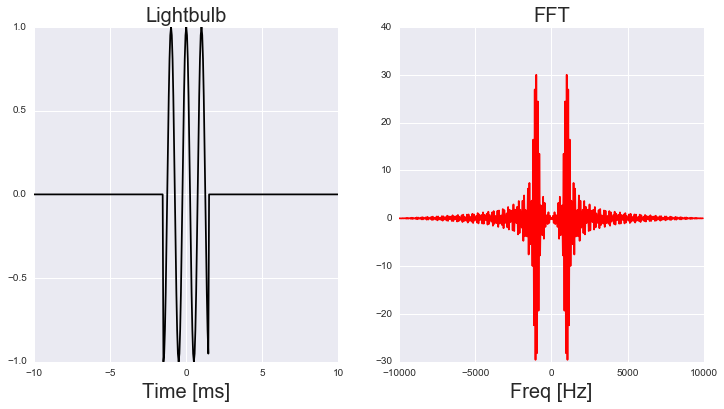

In [2]:
x_light = np.arange(-10, 10, 0.05)
y_light = np.cos(x_light*2*np.pi)
y_light = y_light*(x_light < 1.5)*(x_light > -1.5)
y_fft = fft(y_light)
x_fft = fftfreq(len(x_light), 0.05/1000)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].plot(x_light, y_light, color='k')
axes[0].set_title('Lightbulb', fontsize=20)
axes[0].set_xlabel('Time [ms]', fontsize=20)
axes[1].plot(fftshift(x_fft), fftshift(y_fft), color='r')
axes[1].set_xlabel('Freq [Hz]', fontsize=20)
axes[1].set_title('FFT', fontsize=20)

This is weird. You'd think that, maybe if you filtered the light just right, you could cancel this out (you can't without breaking causality$^*$ but that's another issue) and see the light turning off and on.

There are various ways to deal with this; the most common is to window your signal (multiply it by a function that goes to 0 around some point $t$) and take transforms of the signal at different points in time (much like the song visualizers you might see in Winamp and iTunes), giving a *spectrogram*. Other technique include wavelet analysis and using the Wigner distribution function.

A final way, and our technique of interest here, is to take a Hilbert transform.

$^*$And this causality leads to the [Kramers-Kronig relations](https://en.wikipedia.org/wiki/Kramers%E2%80%93Kronig_relations), which is another Hilbert transform.

### Definition

The Hilbert transform of a function $f(t)$ is the transformation

$$ \mathcal{H}(f)(t) = \frac{1}{\pi} PV \int_{-\infty}^{\infty} \frac{f(\tau)}{t - \tau} d\tau $$ 

...so you're convolving your function $f(t)$ with the kernel $K(t) = 1/(\pi t$).

The *PV* in the above equation means Principal Value, which basically is telling you that for the part where $\tau$ is near $t$, you take an integral with $\tau$ going to $t - \epsilon$ and $t + \epsilon$ with the limit $\epsilon \rightarrow 0$. If you wanted to actually solve this for selected functions, you'd probably be using complex analysis with the Residue Theorem and talk about test functions going to 0 at infinity.

That is a problem for the mathematicians, and is not something we need to bother with. We can get some basic understanding by looking at tables of transforms [e.g. at Wikipedia](https://en.wikipedia.org/wiki/Hilbert_transform#Table_of_selected_Hilbert_transforms), and most critically understanding that the transform of a cosine gives a sine (at the same frequency) and the transform of a sine gives a negative cosine (same frequency).

Plus, we're going to be dealing with numeric data. So you're going to have some convolution kernel like

$$[-1/5, -1/4 -1/3, -1/2, -1, 0, 1, 1/2, 1/3, 1/4, 1/5]/\pi$$

(assuming unit spacing for $t$) and you can ignore any weirdness about the $1/t$ blowup and stuff out at infinity.

Given a Hilbert transform of a function, one will usually create a function $\tilde{f}(t) = f(t) + i\mathcal{H}(f)(t)$ called the __analytic signal__.

### Okay, why do we care?

The cosine $\leftrightarrow$ sine bit of the Hilbert Transform and how we make the analytic signal looks a lot like using the Euler identity $\cos(\theta) + i\sin(\theta) = e^{i \theta}$. So we can think about this as writing our Analytic Signal as $\tilde{f}(t) = A(t)e^{i \theta(t) t}$. Then $A(t)$ gives us the __envelope__ of our signal (our signal is oscillating between the envelope) and $\frac{d}{dt}\theta(t)$ is our __instantaneous frequency__. These two things are much more helpful to know.

In [3]:
### Examples
# Chirp signal
# Decaying signal
# Our lightbulb

#### Example: Chirp signal

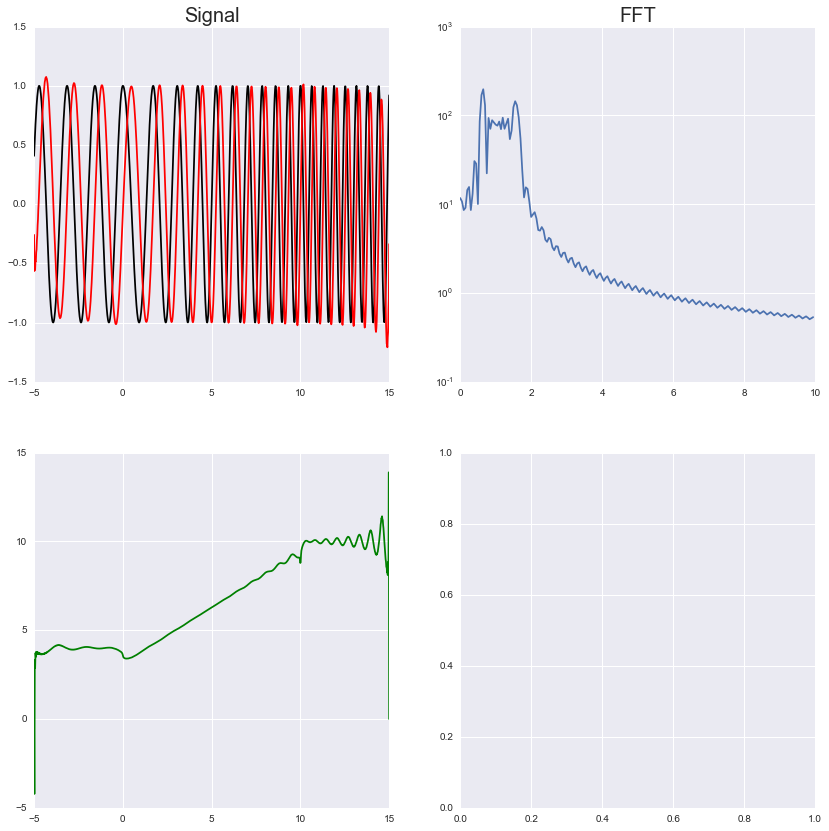

In [121]:
from scipy.signal import chirp

x_chirp = np.linspace(-5, 15, 1000)
dx = x_chirp[1]-x_chirp[0]
# chirp_index = np.logical_and(x_chirp > 0, x_chirp <= 10)
y_chirp = chirp(x_chirp, 0.5, 10, 1.5, method='linear')
y_chirp[x_chirp <= 0] = np.cos(4*x_chirp[x_chirp <= 0])
y_chirp[x_chirp >= 10] = np.cos(10*x_chirp[x_chirp >= 10]+np.pi/8)
fft_chirp = fft(y_chirp)
fftfreqs = fftfreq(len(x_chirp), dx)

ya_chirp = hilbert(y_chirp)

phase_chirp = np.angle(ya_chirp)
phase_chirp = np.unwrap(phase_chirp)
instant_freq = savgol_filter(phase_chirp, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axes[0,0].plot(x_chirp, y_chirp, color='k')
axes[0,0].plot(x_chirp, np.imag(ya_chirp), color='r')
axes[0,0].set_title('Signal', fontsize=20)
axes[0,1].semilogy(fftfreqs[:200], np.abs(fft_chirp[:200]))
axes[0,1].set_title('FFT', fontsize=20)
axes[1,0].plot(x_chirp, instant_freq, color='g')

#### Example: Decaying signal

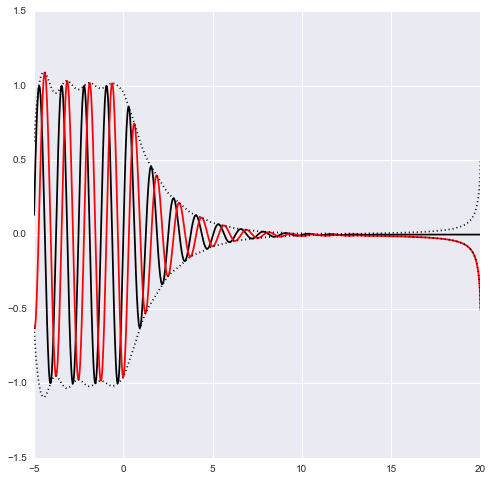

In [98]:
x_decay = np.linspace(-5, 20, 1000)
y_decay = np.exp(-0.5*x_decay)*np.sin(5*x_decay)
y_decay[x_decay < 0] = np.sin(5*x_decay[x_decay < 0])

ya_decay = hilbert(y_decay)
envelope = np.abs(ya_decay)

plt.figure(figsize=(8,8))
plt.plot(x_decay, y_decay, color='k')
plt.plot(x_decay, np.imag(ya_decay), color='r')
plt.plot(x_decay, envelope, color='k', linestyle=':')
plt.plot(x_decay, -envelope, color='k', linestyle=':')

#### Example: Lightbulb

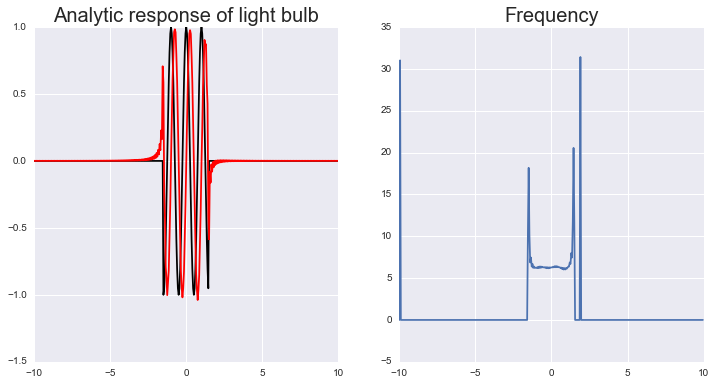

In [133]:
ya_light = hilbert(y_light)

light_phase = np.unwrap(np.angle(ya_light), discont=5)
instant_freq = savgol_filter(light_phase, 3, 1, deriv=1, delta=x_light[1]-x_light[0], mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(x_light, y_light, color='k')
axes[0].plot(x_light, np.imag(ya_light), color='r')
axes[0].set_title('Analytic response of light bulb', fontsize=20)
axes[1].plot(x_light, instant_freq)
axes[1].set_title('Frequency', fontsize=20)

Scipy has two Hilbert transform functions, [`scipy.fftpack.hilbert`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.fftpack.hilbert.html) and [`scipy.signal.hilbert`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.hilbert.html). It looks like the signal one is a bit more useful.

### Properties of the Hilbert Transform and Analytic Signal

- $\mathcal{H}(\mathcal{H}(f(t)) = -f(t)$, up to a constant factor (and we'll get there in a bit...).
- In Fourier space, the Hilbert transform multiplies the Fourier transform by $i \times \text{sgn}(\nu)$. The transform to the analytic signal multiplies the Fourier transform by $2*\Theta(t)$ where $\Theta$ is the Heaviside function (0 at $t<0$, 1 at $t>0$). This means that we've basically cut out all of the negative frequency components of a signal.

In [4]:
### Show this as a fft

- The instantaneous frequency **BEATS** the Gabor limit $\sigma_t \sigma_{\nu} \geq 1/4\pi$. If I was trying to use a spectrogram to figure out what frequency is happening right at the moment, I'd have to balance he width of the window--too wide and it's hard to tell exactly when something is happening, too narrow and I can't really distinguish between frequencies. We don't have that problem with the Hilbert transform.

__ANYTHING ELSE__?

### We run into some difficulties...

The "up to a constant factor" I mentioned in the first property ends up giving us some real headaches. For example, let's look at the function $f(t) = a + \sin(t)$, where we adjust the constant factor $a$ (so we're looking at different reference values).

#### $a = 0$ (the case that works)

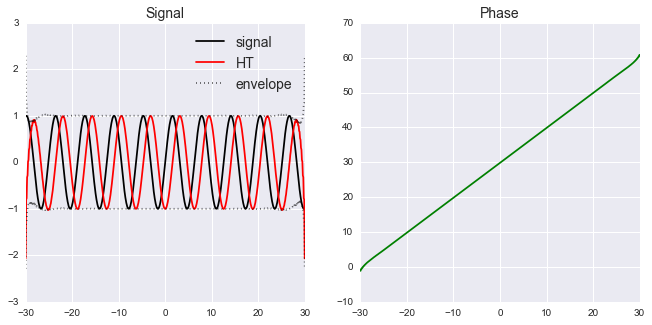

In [114]:
x_test = np.linspace(-30, 30, 600)
y_test = np.sin(x_test) + 0.0
ya_test = hilbert(y_test)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq0 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].plot(x_test, envelope, color='k', alpha=0.6, linestyle=':', label='envelope')
axes[0].plot(x_test, -envelope, color='k', alpha=0.6, linestyle=':')
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

#### $a = 0.5$ (the functions are offset slightly)

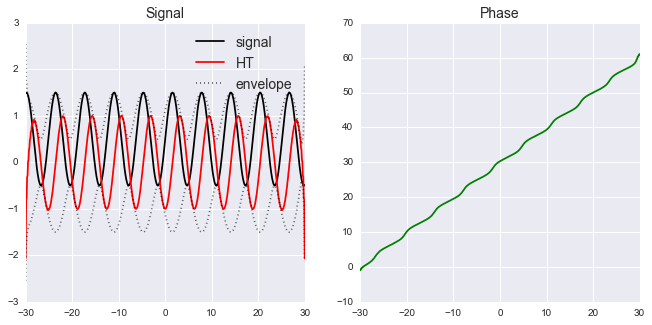

In [115]:
x_test = np.linspace(-30, 30, 600)
y_test = np.sin(x_test) + 0.5
ya_test = hilbert(y_test)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq03 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].plot(x_test, envelope, color='k', alpha=0.6, linestyle=':', label='envelope')
axes[0].plot(x_test, -envelope, color='k', alpha=0.6, linestyle=':')
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

#### $a = 1.2$ (we don't even hit 0)

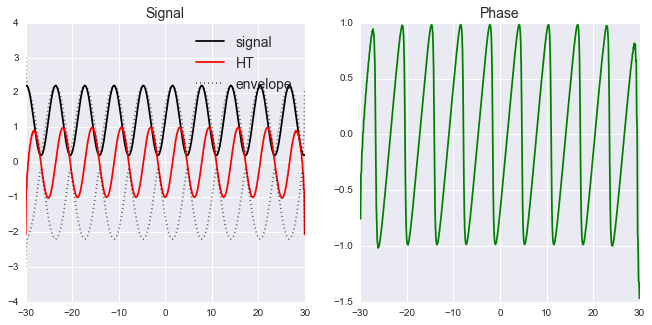

In [116]:
x_test = np.linspace(-30, 30, 600)
y_test = np.sin(x_test) + 1.2
ya_test = hilbert(y_test)
dx = x_test[1]-x_test[0]

envelope = np.abs(ya_test)
phaseterm = np.unwrap(np.angle(ya_test))
instant_freq12 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

axes[0].plot(x_test, np.real(ya_test), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test), color='r', label='HT')
axes[0].plot(x_test, envelope, color='k', alpha=0.6, linestyle=':', label='envelope')
axes[0].plot(x_test, -envelope, color='k', alpha=0.6, linestyle=':')
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=14)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=14)

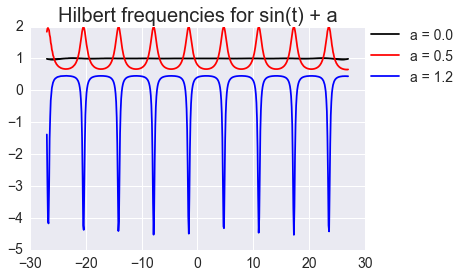

In [117]:

plt.plot(x_test[30:-30], instant_freq0[30:-30], 'k', label='a = 0.0')
plt.plot(x_test[30:-30], instant_freq03[30:-30], 'r', label='a = 0.5')
plt.plot(x_test[30:-30], instant_freq12[30:-30], 'b', label='a = 1.2')
plt.legend(bbox_to_anchor=(1.3, 1.05), fontsize=14)
plt.tick_params(labelsize=14)
plt.title('Hilbert frequencies for sin(t) + a', fontsize=20)

#### Additionally, if we have two dominant frequencies superimposed, we also see odd behavior

$y = \sin(x) + 0.5 \cos(2x)$

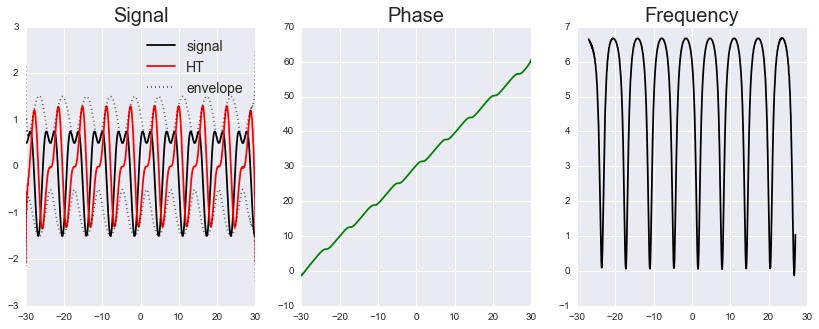

In [113]:
y_test2 = np.sin(x_test) + 0.5*np.cos(2*x_test)
ya_test2 = hilbert(y_test2)

envelope = np.abs(ya_test2)
phaseterm = np.unwrap(np.angle(ya_test2))
instant_freq2 = savgol_filter(phaseterm, 3, 1, deriv=1, delta=dx, mode='mirror')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

axes[0].plot(x_test, np.real(ya_test2), color='k', label='signal')
axes[0].plot(x_test, np.imag(ya_test2), color='r', label='HT')
axes[0].plot(x_test, envelope, color='k', alpha=0.6, linestyle=':', label='envelope')
axes[0].plot(x_test, -envelope, color='k', alpha=0.6, linestyle=':')
axes[0].legend(fontsize=14)
axes[0].set_title('Signal', fontsize=20)
axes[1].plot(x_test, phaseterm, color='g')
axes[1].set_title('Phase', fontsize=20)
axes[2].plot(x_test[30:-30], instant_freq2[30:-30], color='k')
axes[2].set_title('Frequency', fontsize=20)

### The Hilbert-Huang Transform
__REF NORDEN HUANG'S PAPER__

These problems were addressed by Norden Huang in __PAPER REF__. The problem is that the Hilbert Transform works well provided you've got a signal that is centered around 0, especially with your minima being below the 0-line and your maxima above it. So, to do this, we do the following:
- Find an envelope for your signal by finding a cubic spline that goes from maxima to maxima, and another cubic spline that goes from from minima to minima.
- Compute an envelope mean that lies between the two splines.
- Subtract this mean from your signal. The remaining signal can be safely Hilbert-ed.
- Recursively apply this to the subtracted mean until you reach a stopping point.

### An application to financial data

Going through the paper [Application of Hilbert-Huang transform to non-stationary financial time series analysis](https://web.cs.dal.ca/~tt/CSCI690611/papers/plugin-huan_asmbi_2003.pdf)

https://cds.cern.ch/record/1115835?ln=no

http://www.msri.org/people/members/2008cc/Projects/Project_5B_Ice_Core_EMD/HuangWu_EMD_RevGeo_2008.pdf

https://cran.r-project.org/web/packages/hht/index.html

https://pyhht.readthedocs.org/en/latest/